In [1]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import os
import timm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#define variables specific to this model
subject = 'sub01'
roi = 'V4'
preprocessing = 'RAW'
model_name = 'model_weights_{}_{}_{}'.format(subject, roi, preprocessing)
input_data_dims = (32,32,225)
input_channels = input_data_dims[2]


# define global variables / hyperparameters
batch_size = 64
num_epochs = 50
learning_rate = 0.001

# detect if GPU/CPU device
use_cuda = torch.cuda.is_available()
print('CUDA available:', use_cuda)

# set RNG seed for reproducibility
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

# setup gpu things
dtype = 'float32' if use_cuda else 'float64' # GPU does better with float32 numbers
torchtype = {'float32': torch.float32, 'float64': torch.float64}[dtype]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# flush out the cache
torch.cuda.empty_cache()


CUDA available: True


In [2]:
# Training a RNN with PyTorch for roi {roi} with RAW data

# Load the entire training data into main memory
# This is a huge dataset, so we need to do this in chunks

#isolate subject of interests' data
num_subjects = 10
soi = subject

# read in every npy file in the directory Gunners_training_data/{roi}/RAW and store them in a list 
training_data = []
training_labels = []

# load in every Nth file in the directory
culling_scale = 1

# for each file in the directory
for i, file in enumerate(os.listdir('../Gunners_training_data/{}/{}'.format(roi, preprocessing))):
    # if the file name contains the soi string
    if not soi in file:
        continue
    # if the file is a .npy file
    if file.endswith('.npy'):
        # read in the file
        data = np.load('../Gunners_training_data/{}/{}/'.format(roi,preprocessing) + file, allow_pickle=True)
        
        # for each sample, make sure its dimensions are 32x32x225, if not then skip it
        if data[0][0].shape != input_data_dims:
            continue

        # for each sample, add the data to the training_data list
        training_data.append(data[0][0])
        # for each sample, add the label to the training_labels list
        training_labels.append(data[0][1])

#normalize all labels to be between -1 and 1
training_labels = np.array(training_labels)
training_labels = (training_labels - np.min(training_labels)) / (np.max(training_labels) - np.min(training_labels))
#print the value range of the labels
print('Value range of labels: ', np.min(training_labels), np.max(training_labels))

print('Number of training samples: ', len(training_data))
num_classes = training_labels[0].shape[0]
print('Number of voxel activations (classes): ', num_classes)

    
# verify the data is loaded correctly
training_data = np.array(training_data)
training_labels = np.array(training_labels)

# convert the lists to float 32 tensors
training_data = torch.tensor(training_data).type(torchtype)
training_labels = torch.tensor(training_labels).type(torchtype)

# permute the data so that the first dimension is the number of samples, the second is the number of channels
training_data = training_data.permute(0,3,1,2)

#print the dims of training_data tensor
print('training_data tensor dims:', training_data.shape)

# create a dataset from the tensors
my_dataset = TensorDataset(training_data,training_labels) # create your datset

# split the data into training and validation sets
train_size = int(0.8 * len(training_data))
valid_size = len(training_data) - train_size

# create training and validation sets
train_data, valid_data = torch.utils.data.random_split(my_dataset, [train_size, valid_size])

# create training and validation dataloaders
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle=False)


Value range of labels:  0.0 1.0
Number of training samples:  768
Number of voxel activations (classes):  107
training_data tensor dims: torch.Size([768, 225, 32, 32])


In [3]:
# create a loss function that is 1 - the correlation coefficient
def corrcoef_loss_function(output, target):
    x = output
    y = target

    vx = x - torch.mean(x)
    vy = y - torch.mean(y)

    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
    # mse_loss = torch.mean((output - target) ** 2)
    return (1 - cost)**3

In [4]:
# define RNN model with 255 channels
model = timm.create_model('densenet121', num_classes=num_classes, in_chans=input_channels, pretrained=False).to(device)
# make the model use floats
model.float()

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# scheduler for Learning Rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)

# define loss function for multi-variable regression
loss_fn = corrcoef_loss_function


In [5]:
# keep track of training/validation loss
train_losses = []
valid_losses = []

# train the model
#progress bar for training
pbar = tqdm(range(num_epochs))

for epoch in pbar:
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # keep track of training and validation accuracy
    train_accuracy = 0.0
    valid_accuracy = 0.0
    
    # set the model to training mode
    model.train()
    
    # train the model for one epoch
    for i, (data, labels) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data = data.to(device)
            labels = labels.to(device)
        
        # zero out the gradients
        optimizer.zero_grad()
        
        # forward pass
        output = model(data)
        
        # calculate loss
        loss = loss_fn(output, labels)
        
        # backpropagate
        loss.backward()
        
        # update the weights
        optimizer.step()
        
        # calculate the training loss
        train_loss += loss.item()
    
    # set the model to evaluation mode
    model.eval()
    
    # evaluate the model on the validation set
    for i, (data, labels) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data = data.to(device)
            labels = labels.to(device)
        
        # validation forward pass
        output = model(data)

        # calculate the validation loss
        valid_loss += loss_fn(output, labels).item()
    
    # calculate the average training loss and accuracy
    train_loss = train_loss/len(train_loader)

    # calculate the average validation loss and accuracy
    valid_loss = valid_loss/len(valid_loader)

    # ping the learning rate scheduler
    scheduler.step(valid_loss)

    # append the training and validation loss and accuracy to the lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # if current validation loss was best so far, save the model weights in memory
    best_valid_loss = min(valid_losses)
    if valid_loss == best_valid_loss:
        my_best_weights = model.state_dict() 
    
    # display the epoch training loss
    pbar.set_postfix({
                    'Epoch':'{}/{}'.format(epoch+1, num_epochs), 
                    'Training Loss': '{:.4f}'.format(train_loss) , 
                    'Validation loss' : '{:.4f}'.format(valid_loss)})
# assign the best weights to the model
model.load_state_dict(my_best_weights)

#print the epoch of the best validation loss
print('Best validation loss: ', min(valid_losses))
print('Epoch of best validation loss: ', valid_losses.index(min(valid_losses))+1)
# print the model summary
# print(model)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch    14: reducing learning rate of group 0 to 1.0000e-05.
Epoch    17: reducing learning rate of group 0 to 1.0000e-06.
Epoch    20: reducing learning rate of group 0 to 1.0000e-07.
Epoch    23: reducing learning rate of group 0 to 1.0000e-08.
Best validation loss:  0.6866040130456289
Epoch of best validation loss:  8


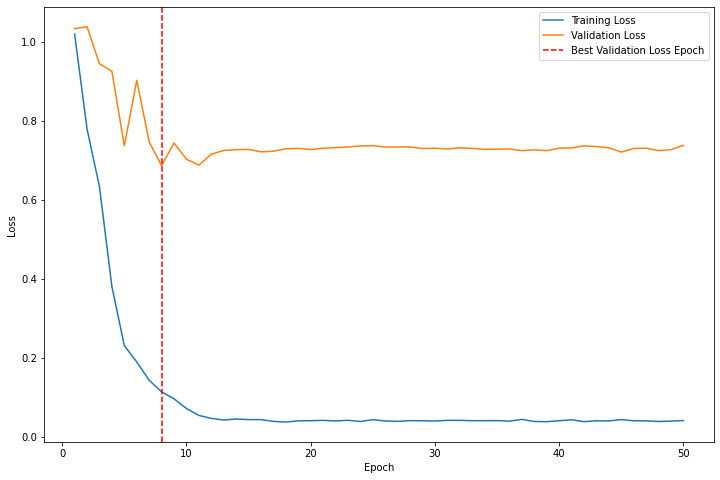

In [6]:
# plot the training and validation loss and accuracy and a vertical line on the x-axis at the epoch of the best validation loss
best_epoch = valid_losses.index(min(valid_losses))+1
plt.figure(figsize=(12,8))
plt.plot(range(1,num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1,num_epochs+1), valid_losses, label='Validation Loss')
plt.axvline(best_epoch, color='r', linestyle='--', label='Best Validation Loss Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [7]:
# load the model weights from file
# model.load_state_dict(torch.load('{}.pt'.format(model_name)))

(1, 107)
Prediction Range:  -0.81096154 1.220321


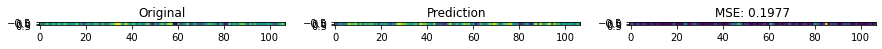

Mean Squared Error:  0.1977049


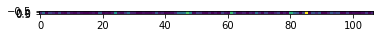

Correlation Coefficient:  0.31188552460728797


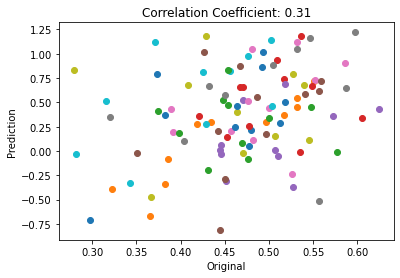

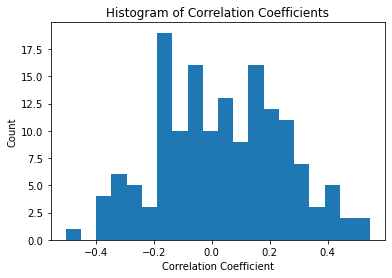

Highest Correlation Coefficient:  0.5469980259268221
Lowest Correlation Coefficient:  -0.5033567506798853
Mean Correlation Coefficient:  0.036677344575933614
Mean Correlation Coefficient:  0.036677344575933614


In [8]:
model.eval()
# display a side by side comparison of the original label and the predicted label
def display_side_by_side(original, prediction):
    #add title to the figure
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(original)
    ax.set_title('Original')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(prediction)
    ax.set_title('Prediction')
    # calculate the mean squared error
    mse = (original - prediction)**2
    # display mse next to the other comparisons
    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('MSE: {:.4f}'.format (mse.mean()))
    ax.imshow(mse)
    plt.show()

# display a figure of the mean squared error between the original label and the predicted label on matplotlib
def display_mse(original, prediction):
    mse = np.mean((original - prediction)**2)
    print('Mean Squared Error: ', mse)
    plt.imshow((original - prediction)**2)
    plt.show()

print(training_labels[0].unsqueeze(0).numpy().shape)

resized_original = training_labels[0].unsqueeze(0).numpy().reshape(1,107)
resized_prediction = model(training_data[0].unsqueeze(0).to(device)).detach().cpu().numpy().reshape(1,107)

#draw a correlation coefficient graph between the original label and the predicted label
def draw_correlation_coefficient(original, prediction):
    # calculate the correlation coefficient
    corr_coeff = np.corrcoef(original, prediction)[0,1]
    # display the correlation coefficient
    print('Correlation Coefficient: ', corr_coeff)
    # plot the correlation coefficient graph
    plt.plot(original, prediction, 'o')
    plt.xlabel('Original')
    plt.ylabel('Prediction')
    plt.title('Correlation Coefficient: {:.2f}'.format(corr_coeff))
    plt.show()


#print out value ranges of prediction
print('Prediction Range: ', np.min(resized_prediction), np.max(resized_prediction))

# display a side by side comparison of the original label and the predicted label
display_side_by_side(resized_original,resized_prediction)
display_mse(resized_original,resized_prediction)

draw_correlation_coefficient(training_labels[0].unsqueeze(0).numpy(),model(training_data[0].unsqueeze(0).to(device)).detach().cpu().numpy())

#find out the correlation coefficient between the original label and the predicted label for the entire dataset
def find_correlation_coeff(valid_dataset):
    # calculate the correlation coefficient
    corr_coeff_list = []
    # separate the pytorch dataset into the data and labels
    # set the model to evaluation mode
    model.eval()
    
    # evaluate the model on the validation set
    for i, (data, labels) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data = data.to(device)
            labels = labels.to(device)
        
        # validation forward pass
        output = model(data).to(device)
        # for each image in the validation set, calculate the correlation coefficient
        for label, prediction in zip(labels, output):
            corr_coeff_list.append(np.corrcoef(label.cpu().numpy(), prediction.detach().cpu().numpy())[0,1])
    # plot a histogram of the correlation coefficients
    plt.hist(corr_coeff_list, bins=20)
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Count')
    plt.title('Histogram of Correlation Coefficients')
    plt.show()

    # calculate the mean correlation coefficient
    mean_corr_coeff = np.mean(corr_coeff_list)
    #print the highest correlation coefficient and lowest correlation coefficient
    print('Highest Correlation Coefficient: ', max(corr_coeff_list))
    print('Lowest Correlation Coefficient: ', min(corr_coeff_list))
    # display the mean correlation coefficient
    print('Mean Correlation Coefficient: ', mean_corr_coeff)    

    return mean_corr_coeff

print ( 'Mean Correlation Coefficient: ', find_correlation_coeff(valid_data))

In [9]:
# find the loss of the model on the validation set
valid_loss = 0.0

# turn the model to evaluation mode
model.eval()
for i, (data, labels) in enumerate(valid_loader):
    # move tensors to GPU if CUDA is available
    if use_cuda:
        data = data.to(device)
        labels = labels.to(device)
    
    # validation forward pass
    output = model(data)
    
    # calculate the validation loss
    valid_loss += loss_fn(output, labels).item()

valid_loss = valid_loss/len(valid_loader)

# print the validation loss
print('Validation loss: ', valid_loss)

Validation loss:  0.7380284070968628


In [10]:
# save the model weights to a file
torch.save(model.state_dict(), '{}.pt'.format(model_name))